# Import needed libraries

In [124]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import skew


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.decomposition import PCA

from sklearn.feature_selection import RFECV, RFE, f_regression


from sklearn.decomposition import PCA

%matplotlib inline

# Methods used

In [125]:
# Remove correlated columns as this has a big impact on regression
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

# Load and split the data

In [126]:
user = pd.read_csv("analysis_data.csv", sep=",", index_col="Client")
print(user.shape)

(1566, 41)


In [127]:
user_tr = user[user['Sale_CL']==1]
print(user_tr.shape)

(282, 41)


In [128]:
user_tr = user_tr.drop(['Sale_MF','Sale_CC','Sale_CL','Revenue_MF','Revenue_CC'], axis=1)

In [129]:
print(user_tr.columns)

Index(['Age', 'Tenure', 'M', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA',
       'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Revenue_CL', 'Actbal_CA_avg',
       'ActBal_SA_avg', 'ActBal_MF_avg', 'ActBal_OVD_avg', 'ActBal_CC_avg',
       'ActBal_CL_avg'],
      dtype='object')


Outliers are removed from the dataset

In [130]:
user_tr = user_tr.loc[user_tr['Revenue_CL']<30 ]

In [131]:
user_tr_X = user_tr.drop('Revenue_CL', axis=1)
user_tr_Y = user_tr['Revenue_CL']

Highly correlated datasets are removed from the dataset

In [132]:
user_tr_X= correlation(user_tr_X,0.7)

In [133]:
print(user_tr_X.columns)

Index(['Age', 'Tenure', 'M', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'VolumeCred', 'TransactionsCred',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'TransactionsDebCash_Card'],
      dtype='object')


In [134]:
user_tr_Y.shape

(276,)

## Correlation

In [135]:
for col in user_tr_X.columns:
    print(col)
    print(np.corrcoef(user_tr_Y,user_tr_X[col])[0][1])

Age
0.0799865345485
Tenure
0.016876411833
M
-0.029242612884
Count_CA
0.0374357184154
Count_SA
0.0501905103332
Count_MF
0.0117911525482
Count_OVD
0.014666350739
Count_CC
-0.0983570405612
Count_CL
0.133911162898
ActBal_CA
0.093778010144
ActBal_SA
0.0737905738047
ActBal_MF
0.104144133165
ActBal_OVD
-0.0149233522036
ActBal_CC
-0.11686042686
VolumeCred
-0.0296183814778
TransactionsCred
-0.0107544434629
VolumeDebCash_Card
-0.0164064099277
VolumeDebCashless_Card
-0.0223855404496
TransactionsDebCash_Card
-0.0413631081402


As seen no real correlation exist between the target and one of the remaining variables

# Preprocessing

## check for skewness and log transform if needed

In [136]:
#log transform skewed numeric features:
user_skew = user_tr_X.drop('M', axis=1)
skewed_feats = user_skew.apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

user_tr_X[skewed_feats] = np.log1p(user_tr_X[skewed_feats])

## Check target variable

In [137]:
user_tr_Y.describe()

count    276.000000
mean      11.165608
std        6.096673
min        1.071429
25%        6.245982
50%       10.589286
75%       15.099643
max       29.781071
Name: Revenue_CL, dtype: float64

In [167]:
user_tr_Y.shape

(276,)

In [138]:
user_tr_Y.sort_values(ascending = False).head(10)

Client
553     29.781071
83      28.685357
729     28.148929
1083    27.551786
1058    27.323571
415     27.257500
1298    25.243214
900     24.797500
1231    24.434643
1425    24.250000
Name: Revenue_CL, dtype: float64

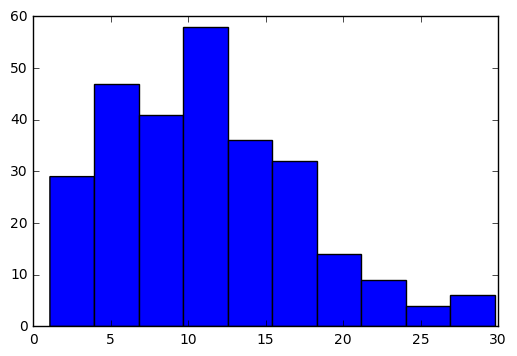

In [139]:
plt.hist(user_tr_Y)
plt.show()

The target will be log transformed

In [140]:
user_tr_Y = np.log1p(user_tr_Y)
user_tr_X.replace(np.NaN, 0, inplace=True)

# Choose model

In [141]:
reg = BayesianRidge()
scores = cross_val_score(reg, user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

neg_mean_squared_error: -0.33 (+/- 0.15)
[-0.32784748 -0.26075338 -0.32850839 -0.49293617 -0.37546904 -0.38547841
 -0.23361595 -0.27520174 -0.2593813  -0.35967968]


In [142]:
reg = Lasso()
scores = cross_val_score(reg, user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.33 (+/- 0.15)


In [143]:
reg = Ridge()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.34 (+/- 0.19)


In [144]:
reg = RandomForestRegressor()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.39 (+/- 0.17)


In [145]:
reg = GradientBoostingRegressor()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.41 (+/- 0.21)


## Scaling the params

In [146]:
#Scale the 
user_tr_X_scale = scale(user_tr_X)
user_tr_Y_scale = scale(user_tr_Y)

In [147]:
svr = SVR(kernel='linear')
scores = cross_val_score(svr,user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.05 (+/- 0.71)


In [148]:
svr = SVR(kernel='rbf')
scores = cross_val_score(svr,user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.14 (+/- 0.64)


In [149]:
reg = KNeighborsRegressor()
scores = cross_val_score(reg,user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.16 (+/- 0.62)


In [150]:
reg = Lasso()
scores = cross_val_score(reg, user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.01 (+/- 0.45)


## check if improvements with polynomial features

In [151]:
poly = PolynomialFeatures(degree=3)
user_tr_X_pol = poly.fit_transform(user_tr_X)

In [152]:
reg = Lasso(normalize=True)
scores = cross_val_score(reg, user_tr_X_pol, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.33 (+/- 0.14)


# PCA

Maybe some PCA will improve it but probably not as Lasso already removes the unnecessary variables by regularization

In [153]:
#dimension reduction
pca = PCA(n_components=10)
X_pca_20 = pca.fit_transform(user_tr_X)
X_pca_20.shape

(276, 10)

In [154]:
reg = Lasso()
scores = cross_val_score(reg, X_pca_20, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.33 (+/- 0.15)


# Result

# The Lasso algo is the best and we will use it for prediction

# Optimization of the algorithm

In [155]:
search = { 'alpha':[0.001,0.1,0.5, 0.7, 1], 'tol':[0.5, 1,5,10]}


lasso = Lasso()

lasso_grid = GridSearchCV(estimator=lasso,param_grid=search, scoring='neg_mean_squared_error', n_jobs=-1,refit=True, cv=10)

lasso_grid.fit( user_tr_X, user_tr_Y)

print(lasso_grid.best_estimator_)

print(lasso_grid.best_params_)

print(lasso_grid.best_score_)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.5, warm_start=False)
{'tol': 0.5, 'alpha': 0.1}
-0.327371446859


Let's have a quick look at the residuals of the estimator. 
These should follow a random pattern.

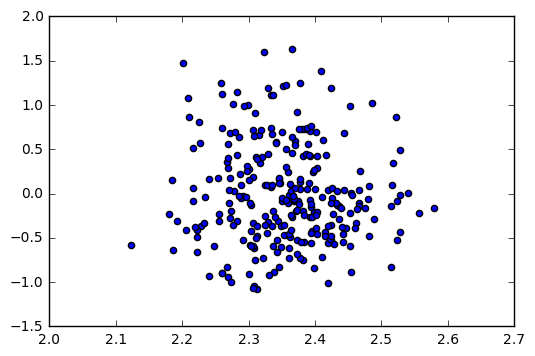

In [156]:
plt.scatter(lasso_grid.predict(user_tr_X), lasso_grid.predict(user_tr_X)-user_tr_Y)

Looks pretty random :)

# Fit the model and predict the missing values

In [157]:
user_pred = pd.read_csv("consumer_loan_prop_pred.csv", sep=",", index_col="Client")
print(user_pred.shape)

(629, 36)


In [158]:
user_pred_X = user_pred.ix[(user_pred['Sale_CL_pred']==1)]
user_pred_X = user_pred_X.drop('Sale_CL_pred', axis=1)


In [159]:
user_pred_X[skewed_feats] = np.log1p(user_pred_X[skewed_feats])

In [160]:
user_pred_X.head()

,Age,Tenure,M,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Actbal_CA_avg,ActBal_SA_avg,ActBal_MF_avg,ActBal_OVD_avg,ActBal_CC_avg,ActBal_CL_avg
Client,,,,,,,,,,,,,,,,,,,,,
267,73.0,36,0.0,0.693147,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,12,0.693147,7,2,0.000000,0.0,0.000000,0.0000,0.0,0.0
1243,78.0,51,1.0,1.098612,0.0,1.386294,0.000000,0.0,0.0,0.829175,...,17,1.386294,0,9,0.645714,0.0,2915.261905,0.0000,0.0,0.0
919,29.0,5,0.0,0.693147,0.0,0.000000,0.693147,0.0,0.0,5.541310,...,22,1.609438,7,8,254.011786,0.0,0.000000,0.0000,0.0,0.0
144,67.0,104,1.0,0.693147,0.0,0.000000,0.000000,0.0,0.0,7.103151,...,3,0.693147,2,0,1214.792143,0.0,0.000000,0.0000,0.0,0.0
1440,29.0,96,1.0,0.693147,0.0,0.000000,0.693147,0.0,0.0,7.231046,...,34,1.791759,20,3,1380.666429,0.0,0.000000,152.2775,0.0,0.0


In [161]:
user_pred_Y = np.expm1(lasso_grid.predict(user_pred_X[user_tr_X.columns]))

In [162]:
user_pred_Y

array([  9.63855926,  10.02841839,   9.01760911,  11.00269474,
         9.43377858,   9.66462973,   8.7997538 ,  10.22026293,
         8.97731091,   8.28054218,   9.534958  ,   9.91804148,
         9.41580867,   7.70279096,   8.65903746,   8.53736614,
         8.97390303,  10.19066409,   8.11085096,   8.7177966 ,
         7.17708737,   8.61740695,  10.27523493,   9.2882886 ,
         9.3345816 ,   9.34756662,   7.75198532,  10.23872829,
        10.0201455 ,   8.90889859,   9.27773708,   9.77806286,
         8.36138672,  10.84335695,   9.02490359,  10.03952729,
         8.69684682,  10.26476222,   9.80726594,  10.48885856,
         9.88422192,   9.03151918,   9.07099623,   9.29798852,
         9.85749083,   9.01348011,   9.94464716,  10.40045671,
         9.76320165,   9.97807987,   8.39299745,  10.26830751,
         8.53526744,  10.47748882,   8.80501431,   9.79576774,
         9.36716423,   8.82829653,   9.11717487,   9.36408243,
         9.65024415,   9.61409779,  10.87097595,   8.72

In [163]:
user_pred = user_pred.ix[(user_pred['Sale_CL_pred']==1)]
user_pred['Sale_CL_pred_value'] = pd.Series(user_pred_Y,index=user_pred.index)

In [164]:
user_pred['Sale_CL_pred_value'].shape

(160,)

In [165]:
user_pred['Sale_CL_pred_value'].describe()

count    160.000000
mean       9.267561
std        0.708498
min        7.177087
25%        8.827177
50%        9.288634
75%        9.744737
max       11.002695
Name: Sale_CL_pred_value, dtype: float64

In [166]:
user_pred.to_csv(path_or_buf='consumer_loan_prop_pred_value.csv')